In [1]:
import torch
import torch.nn as nn
import torch.autograd
from torch.autograd import Variable
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
import torchvision.models as models
import torch.utils.data as data

In [2]:
torch.cuda.manual_seed_all(225)
np.random.seed(225)

In [3]:
#### cvt2tensor = transforms.ToTensor()
cvt2pil = transforms.ToPILImage()

class Spacenet_Dataset(data.Dataset):
    def __init__(self, annotationsFile,train = True, transform=None):
        files = open(annotationsFile,'r')
        self.transform=transform
        items=[]
        #print(lines[0].split('\n'))
        for line in files:
            #print(line)
            imp,_ = line.split('\n')
            ip,out = imp.split(' ')
            ip = ip
            out = out[:-4]+'segcls.png'
            item = [ip,out]
            items.append(item)
        self.data = items
        self.inp_img_paths=[]
        self.out_img_paths=[]
        self.in_images = []
        self.out_images = []
        for dat in self.data:
            self.inp_img_paths.append(dat[0])
            self.out_img_paths.append(dat[1])

        
        for i in range(len(self.out_img_paths)):
            with Image.open(self.out_img_paths[i]) as handle:
                img = handle.convert('L')
                image_ar = np.where(np.asarray(img) != 0, 1, 0)
                building_ratio = float(np.count_nonzero(image_ar))/(image_ar.size)
                if(building_ratio >= 0.24):
                    self.out_images.append(image_ar)
                    with Image.open(self.inp_img_paths[i]) as handle:
                        self.in_images.append(handle.convert('RGB'))
                
        
 
                    
    
    def __getitem__(self, index):

        in_image = self.in_images[index]
        out_image = self.out_images[index]
        
        if self.transform is not None:
            in_image = self.transform(in_image)
            out_image = self.transform(out_image.reshape(400,400,1))
        
   
        return in_image, out_image

    
    def __len__(self):
        return len(self.in_images)

imgTransform = transforms.Compose([transforms.ToTensor()])
#imgTransformAugment =  transforms.Compose([transforms.RandomHorizontalFlip()])


trainData = Spacenet_Dataset("/home/dipshil/spacenet_data/annotations/trainval.txt",
                             transform=imgTransform)
valData = Spacenet_Dataset("/home/dipshil/spacenet_data/annotations/test.txt",
                           transform=imgTransform)

In [4]:
len(trainData)

461

In [5]:
class MyNet(nn.Module):
    def __init__(self):
        super(MyNet, self).__init__()
        # Convolutional layers.
        
        self.conv1 = nn.Conv2d(3, 8, 8, padding = 2)
        self.conv2 = nn.Conv2d(8, 16, 6)
        self.conv3 = nn.Conv2d(16, 32, 7)
        self.conv4 = nn.Conv2d(32, 64, 3)
        self.conv5 = nn.Conv2d(64, 128, 3)
        self.conv6 = nn.Conv2d(128, 256, 3)
        self.conv7 = nn.Conv2d(256, 512, 3)
        
        self.deconv1 = nn.ConvTranspose2d(512,256,3)
        self.deconv2 = nn.ConvTranspose2d(256,128,3)
        self.deconv3 = nn.ConvTranspose2d(128,64,3)
        self.deconv4 = nn.ConvTranspose2d(64,32,3)
        self.deconv5 = nn.ConvTranspose2d(32,16,7)
        self.deconv6 = nn.ConvTranspose2d(16,8,6)
        self.deconv7 = nn.ConvTranspose2d(8,1,8, padding = 2)
        
        self.Norm_1 = nn.BatchNorm2d(8)
        self.Norm_2 = nn.BatchNorm2d(16)
        self.Norm_3 = nn.BatchNorm2d(32) 
        self.Norm_4 = nn.BatchNorm2d(64) 
        self.Norm_5 = nn.BatchNorm2d(128) 
        self.Norm_6 = nn.BatchNorm2d(256) 
        self.Norm_7 = nn.BatchNorm2d(512)
        self.Norm_9 = nn.BatchNorm2d(256)
        self.Norm_10 = nn.BatchNorm2d(128)
        self.Norm_11 = nn.BatchNorm2d(64)
        self.Norm_12 = nn.BatchNorm2d(32)
        self.Norm_13 = nn.BatchNorm2d(16)
        self.Norm_14 = nn.BatchNorm2d(8)
        
        
        self.pool2 = nn.MaxPool2d(2,return_indices=False)
        
        self.dropout = nn.Dropout(0.5)
        #self.pool3 = nn.MaxPool2d(3,return_indices=False)
        
        self.upsample2 = nn.Upsample(scale_factor = 2)
        #self.upsample3 = nn.Upsample(scale_factor = 3)
        #self.upsample2 = nn.Upsample(size = (256, 98, 98))
        #self.upsample4 = nn.Upsample()
        #self.upsample6 = nn.Upsample()
        
        #self.sigmoid = nn.Sigmoid()
        self.relu = nn.ReLU()
        
    def forward(self, x):
        
        outc1 = self.relu(self.conv1(x))
        outc1 = self.Norm_1(outc1)
        
        outc2 = self.relu(self.conv2(outc1))
        outc2 = self.Norm_2(outc2)
        outc3 = self.pool2(outc2)
        
        outc3 = self.relu(self.conv3(outc3))
        outc3 = self.Norm_3(outc3)
        
        outc4 = self.relu(self.conv4(outc3))
        outc4 = self.dropout(outc4)
        outc4 = self.Norm_4(outc4)
        outc5 = self.pool2(outc4)
        
        outc5 = self.relu(self.conv5(outc5))
        outc5 = self.Norm_5(outc5)
        
        outc6 = self.relu(self.conv6(outc5))
        outc6 = self.dropout(outc6)
        outc6 = self.Norm_6(outc6)
        outc7 = self.pool2(outc6)
        
        outc7 = self.relu(self.conv7(outc7))
        outc7 = self.Norm_7(outc7)
        
        outd1 = self.relu(self.deconv1(outc7))
        outd1 = self.Norm_9(outd1)
        outd2 = self.upsample2(outd1)
        
        outd2 = outd2 + outc6
        outd2 = self.relu(self.deconv2(outd2))
        outd3 = self.Norm_10(outd2)
        
        outd3 = outd3 + outc5
        outd3 = self.relu(self.deconv3(outd2))
        outd4 = self.Norm_11(outd3)
        
        outd4 = self.upsample2(outd4)
        outd4 = outd4 + outc4 
        outd4 = self.relu(self.deconv4(outd4))
        outd4 = self.dropout(outd4)
        outd5 = self.Norm_12(outd4)
        
        outd5 = outd5 + outc3 
        outd5 = self.relu(self.deconv5(outd5))
       
        outd6 = self.upsample2(outd5)
        outd6 = self.Norm_13(outd6)
        
        outd6 = outd6 + outc2 
        outd6 = self.relu(self.deconv6(outd6))
        outd7 = self.Norm_14(outd6)
        
        outd7 = outd7 + outc1 
        outd7 = self.relu(self.deconv7(outd7))
        
        #print(outd7.size())
        return outd7
        #return self.sigmoid(outd7)

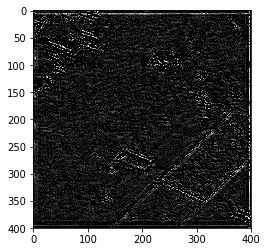

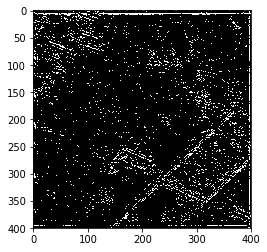

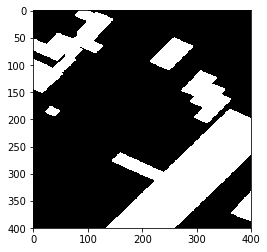

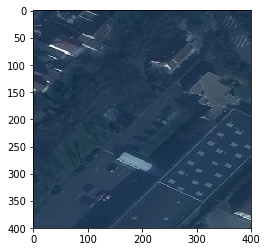

In [6]:
import random

imgTransform = transforms.Compose([transforms.ToTensor()])

def get_sample(model):
   # change it to Valdata if necessary, dont forget to change value inside rand()
    inp,out = valData[random.randint(0,97)]
    inp = inp.view(-1,3,400,400)
    sample_ip = torch.autograd.Variable(inp)
    sample_out = model(sample_ip)
    #print(sample_out.size())
    sample_out1 = sample_out.view(-1,sample_out.size(2),sample_out.size(3))
    #print(sample_out1.data)
    #sample_out1.data = sample_out1.data.clamp_(0,1)
    sample_out1 = cvt2pil(sample_out1.data.cpu()).convert('RGB')
    plt.imshow(sample_out1)
    plt.show()
    sample_out1 = np.where(np.asarray(sample_out1) >= 67,255,0)
    sample_out1 = cvt2pil(imgTransform(sample_out1))
    plt.imshow(sample_out1)
    plt.show()
    plt.imshow(cvt2pil(out.view(-1,400,400) * 255).convert('RGB') )
    plt.show()
    #sample_out = sample_out.view(-1,sample_out.size(2),sample_out.size(3))
    #sample_out1 = np.where(np.asarray(sample_out1.data.cpu().numpy()) >= 0, 0, 255)
    #sample_out = np.int32(sample_out)
    #imgTransform = transforms.Compose([transforms.ToTensor()])
    #sample_out = torch.from_numpy(sample_out)
    #sample_out = cvt2pil(sample_out.view(-1,400,400)) 
    sample_inp = cvt2pil(inp.view(-1,400,400)) 
    #print(sample_inp.shape)
    #print(out.shape)
    plt.imshow(sample_inp)
    plt.show()
    #plt.imshow(sample_out)
    #plt.show()
    #return (sample_out, sample_inp, out)
    
model = MyNet()
#modelS = StanfordNet()
get_sample(model)

In [ ]:
imgTransform = transforms.Compose([transforms.ToTensor()])
imgTransformAugment =  transforms.Compose([transforms.RandomHorizontalFlip()])


trainData = Spacenet_Dataset("/home/dipshil/spacenet_data/annotations/trainval.txt",
                             transform=imgTransform)
valData = Spacenet_Dataset("/home/dipshil/spacenet_data/annotations/test.txt",
                           transform=imgTransform)

trainLoader = torch.utils.data.DataLoader(trainData, batch_size = 2, 
                                          shuffle = True, num_workers = 16)
valLoader = torch.utils.data.DataLoader(valData, batch_size = 2, 
                                        shuffle = False, num_workers = 16)

In [ ]:
from tqdm import tqdm as tqdm

train_loss=[]
test_loss=[]

def train_rnn_model(model, criterion, optimizer, trainData, valData, n_epochs = 10, use_gpu = False):      
    
    if use_gpu:
        print('using GPU!')
        model = model.cuda()
        criterion = criterion.cuda()
        
    # Training loop.
    for epoch in range(0, n_epochs):
        cum_loss = 0.0
        accuracy = 0
        
        # Make a pass over the training data.
        t = tqdm(trainData, desc = 'Training epoch %d' % epoch)
        model.train()  # This is important to call before training!
        for (i,(input_image, target)) in enumerate(t): 
            
            #input_image = torch.autograd.Variable(ip_image)
            #target = torch.autograd.Variable(out_image)
            
            input_image_crop1 = Variable(input_image[:,:,:200,:200])
            target_crop1 = Variable(target[:,:,:200,:200])
            
            input_image_crop2 = Variable(input_image[:,:,200:,:200])
            target_crop2 = Variable(target[:,:,200:,:200])
            
            input_image_crop3 = Variable(input_image[:,:,:200,200:])
            target_crop3 = Variable(target[:,:,:200,200:])
            
            input_image_crop4 = Variable(input_image[:,:,200:,200:])
            target_crop4 = Variable(target[:,:,200:,200:])
            
            if use_gpu:
                input_image_crop1 = input_image_crop1.cuda()
                target_crop1 = target_crop1.cuda()

                input_image_crop2 = input_image_crop2.cuda()
                target_crop2 = target_crop2.cuda()

                input_image_crop3 = input_image_crop3.cuda()
                target_crop3 = target_crop3.cuda()

                input_image_crop4 = input_image_crop4.cuda()
                target_crop4 = target_crop4.cuda()
            
            
            y_ = model(input_image_crop1)
            loss = criterion(y_,target_crop1)
            cum_loss += loss.data[0]
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()    
            
            y_ = model(input_image_crop2)
            loss = criterion(y_, target_crop2)
            cum_loss += loss.data[0]
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            y_ = model(input_image_crop3)
            loss = criterion(y_, target_crop3)
            cum_loss += loss.data[0]
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            y_ = model(input_image_crop3)
            loss = criterion(y_, target_crop3)
            cum_loss += loss.data[0]
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # logging information.
            t.set_postfix(loss = cum_loss / (1 + i)) 

        train_loss.append(cum_loss/(i+1))


        # Make a pass over the validation data.
        cum_loss = 0.0
        accuracy = 0
        
        t = tqdm(valData, desc = 'Validation epoch %d' % epoch)
        model.eval()  # This is important to call before evaluating!
        for (i,(ip_image,out_image)) in enumerate(t): 
        
            input_image = torch.autograd.Variable(ip_image)
            target = torch.autograd.Variable(out_image)

            if use_gpu:
                input_image = input_image.cuda()
                target = target.cuda()
                
            y_ = model(input_image)

            loss = criterion(y_, target)
            cum_loss += loss.data[0]
            
        test_loss.append(cum_loss/(i+1))
    return model

model = MyNet()
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.5e-5, weight_decay = 0.01 , betas = (0.9, 0.999))


# Train the previously defined model.
trained_model = train_rnn_model(nn.DataParallel(model), criterion, optimizer, trainLoader, valLoader, n_epochs = 5, use_gpu = True)

Training epoch 0:   0%|          | 0/231 [00:00<?, ?it/s]

using GPU!


Training epoch 3:  68%|██████▊   | 156/231 [00:30<00:14,  5.09it/s, loss=2.78]

In [ ]:
get_sample(trained_model.cuda())

In [ ]:
plt.plot(train_loss)
plt.show()
plt.plot(test_loss)
plt.show()

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr = 0.5e-6, weight_decay = 0.01 , betas = (0.9, 0.999))
trained_model = train_rnn_model(trained_model, criterion, optimizer, trainLoader, valLoader, n_epochs = 5, use_gpu = True)

In [ ]:
get_sample(trained_model.cuda())

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr = 0.5e-7, weight_decay = 0.01 , betas = (0.9, 0.999))
trained_model = train_rnn_model(trained_model, criterion, optimizer, trainLoader, valLoader, n_epochs = 5, use_gpu = True)

In [ ]:
get_sample(trained_model.cuda())

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr = 0.5e-8, weight_decay = 0.01 , betas = (0.9, 0.999))
trained_model = train_rnn_model(trained_model, criterion, optimizer, trainLoader, valLoader, n_epochs = 5, use_gpu = True)

In [ ]:
get_sample(trained_model.cuda())

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr = 0.5e-9, weight_decay = 0.01 , betas = (0.9, 0.999))
trained_model = train_rnn_model(trained_model, criterion, optimizer, trainLoader, valLoader, n_epochs = 5, use_gpu = True)

In [ ]:
get_sample(trained_model.cuda())

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr = 0.5e-10, weight_decay = 0.1 , betas = (0.9, 0.999))
trained_model2 = train_rnn_model(trained_model, criterion, optimizer, trainLoader, valLoader, n_epochs = 5, use_gpu = True)

In [ ]:
get_sample(trained_model2.cuda())

In [ ]:
plt.plot(train_loss)
plt.show()
plt.plot(test_loss)
plt.show()

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr = 0.5e-11, weight_decay = 0.1 , betas = (0.9, 0.999))
trained_model2 = train_rnn_model(trained_model2, criterion, optimizer, trainLoader, valLoader, n_epochs = 5, use_gpu = True)

In [ ]:
get_sample(trained_model2.cuda())